# Head

In [48]:
import numpy as np
import pandas as pd
import time
import serial
from matplotlib import pyplot as plt
%matplotlib widget

In [49]:
# from tensorflow.keras.utils import to_categorical
from comet_ml import Experiment

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, learning_curve, StratifiedKFold, LearningCurveDisplay
from sklearn.metrics import classification_report, f1_score

from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.display import clear_output

# Hyperopt
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

In [50]:
palm_file = './data/2023-05-31_17-14-41.palm'
model_name = None # LogisticRegression
model = LogisticRegression(max_iter=1000,C=1)
OFFSET = 20 # Смещение
# comet.ml data
API_KEY = ''
PROJECT_NAME = ''
WORKSPACE = ''
# do list
DO_DRAW_PLOTS = True # Построение графиков
DO_HYPEROPT = False # Поиск гиперпараметров hyperopt
DO_MMSCALER = True # Скалирование данных
DO_PLOT_LEARNING_CURVE = False # Нарисовать график кривой обучения
DO_OFFLINE_INFERENCE = False # Оффлайн проверка инференса
DO_ONLINE_INFERENCE = False # Онлайн проверка инференса
DO_LOG = False # Логирование 

DO_MINUS_TREND = False # Минус тренд
DO_REPLACE_TO_MOVING_AVERAGE = True # Заменяем на скользящее среднее

In [93]:
try: print_report() 
except: pass

========================= Train =========================
              precision    recall  f1-score   support

     Neutral       0.92      0.98      0.95     10171
        Open       0.99      0.84      0.91      1104
      Pistol       0.96      0.85      0.90      1078
       Thumb       0.94      0.79      0.86      1104
          OK       0.91      0.79      0.84      1104
        Grab       0.96      0.92      0.94      1118

    accuracy                           0.93     15679
   macro avg       0.95      0.86      0.90     15679
weighted avg       0.93      0.93      0.93     15679

========================= Test =========================
              precision    recall  f1-score   support

     Neutral       0.92      0.95      0.94      2488
        Open       0.97      0.85      0.90       276
      Pistol       0.90      0.93      0.92       296
       Thumb       0.85      0.53      0.65       276
          OK       0.72      0.85      0.78       276
        Grab     

# IO utils


In [52]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

In [53]:
def print_report():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print('='*25,'Train','='*25)
    print(classification_report(y_train, y_pred_train, target_names=GESTURES))
    print('='*25,'Test','='*25)
    print(classification_report(y_test, y_pred_test, target_names=GESTURES))

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [54]:
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape) 
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


In [55]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [56]:
# Списки с названиями признаков
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ALL_CH = OMG_CH + ACC_CH + GYR_CH
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']
# Проверка что списки нужной длины
assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


### OMG_CH

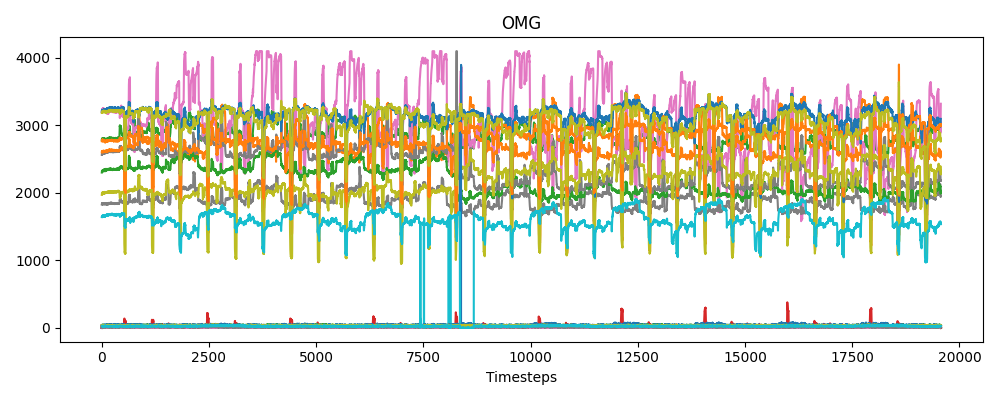

In [57]:
if DO_DRAW_PLOTS:
    # График показаний датчиков
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[OMG_CH].values)
    plt.title('OMG')
    plt.xlabel('Timesteps')
    plt.tight_layout()

In [58]:
if DO_MINUS_TREND: # Вычитание тренда
    for col in OMG_CH:
        #производим декомпозицию временного ряда 
        decomposition = seasonal_decompose(gestures[col],period=645)
        gestures[col] = gestures[col] - decomposition.trend.bfill().ffill() # decomposition.resid.bfill().ffill() + decomposition.seasonal
if DO_REPLACE_TO_MOVING_AVERAGE: # Замена на скользящее среднее
    for col in OMG_CH:
        #производим декомпозицию временного ряда 
        gestures[col] = gestures[col].rolling(window=5).mean().bfill()

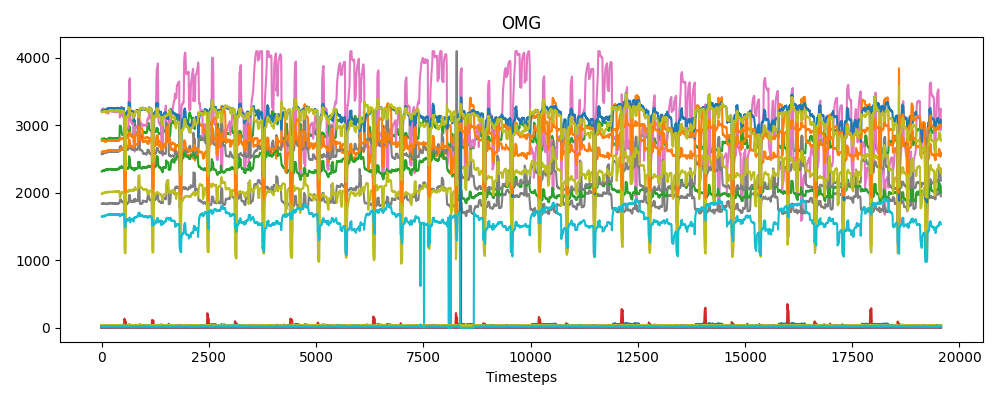

In [59]:
if DO_DRAW_PLOTS:
    # График показаний датчиков после изменений
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[OMG_CH].values)
    plt.title('OMG')
    plt.xlabel('Timesteps')
    plt.tight_layout()

### ACC GYR

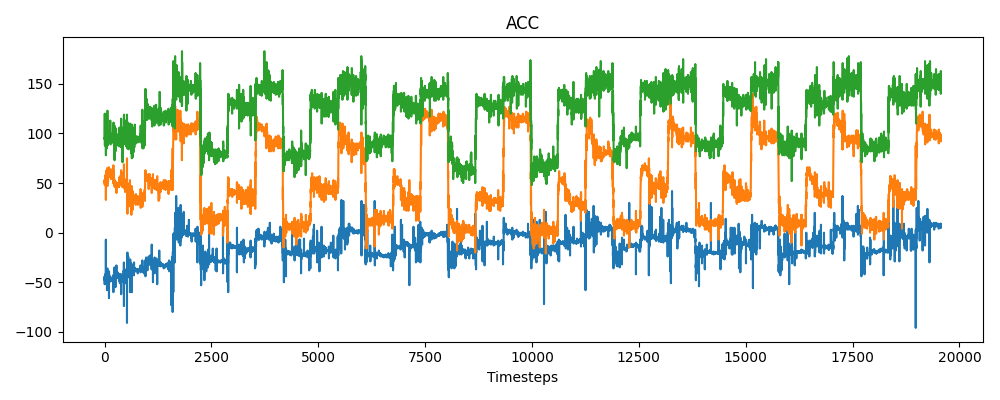

In [60]:
if DO_DRAW_PLOTS:
    # График показаний акселерометров
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[ACC_CH].values)
    plt.title('ACC')
    plt.xlabel('Timesteps')
    plt.tight_layout()

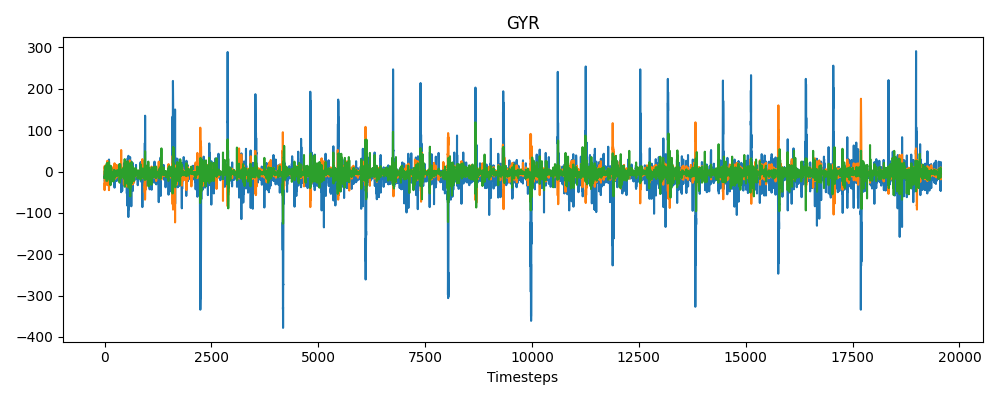

In [61]:
if DO_DRAW_PLOTS:
    # График показаний акселерометров
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[GYR_CH].values)
    plt.title('GYR')
    plt.xlabel('Timesteps')
    plt.tight_layout()

### Protocol

In [62]:
# Целевые признаки сгибаний и разгибаний пальцев руки
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
176,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
177,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
178,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [63]:
# Перекодируем 10 признаков в 1 целевой признак 
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        #'Pronation',
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch',
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        #'Pronation',
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch',
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
# Оказалось только 6 уникальных комбинаций сгибаний и растягиваний пальцев
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [64]:
# Список всех 6 жестов
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [65]:
# Жесты в разные эпохи, 1 эпоха = 1 жест
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int32

In [66]:
# Расширенный целевой признак
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
print(y_cmd.shape)
y_cmd

(19568,)


array([0, 0, 0, ..., 0, 0, 0])

In [67]:
# Расширенный признак поворота руки
y_pronation = np.array([gestures_protocol['Pronation'].loc[s] for s in gestures['SYNC'].values])
print(y_pronation.shape)
y_pronation

(19568,)


array([0., 0., 0., ..., 0., 0., 0.])

## Offset Protocol

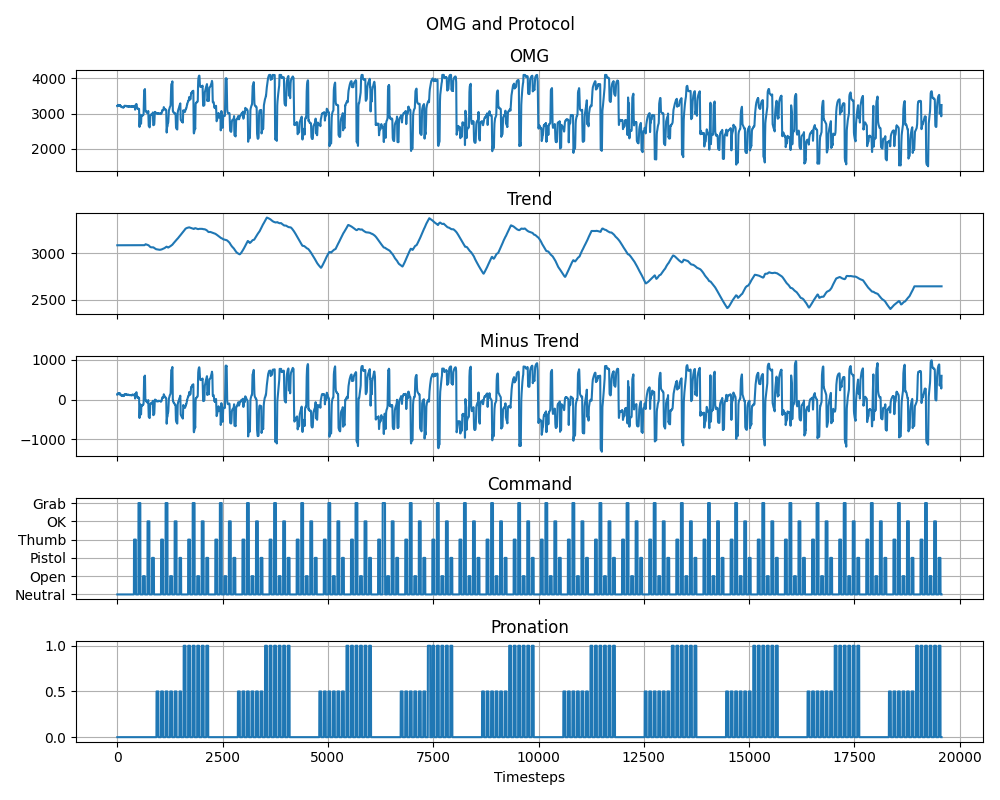

In [68]:
if DO_DRAW_PLOTS:
    col = '16'
    period = 645*2
    
    fig, axx = plt.subplots(5, 1, sharex=True, figsize=(10, 8))
    plt.sca(axx[0])
    plt.plot(gestures[col].values) # OMG_CH
    #plt.yticks(np.arange(0, 4500,500))
    #plt.pcolor(scaled_data.T)
    plt.grid()
    plt.title('OMG')
    
    plt.sca(axx[1])
    decomposition = seasonal_decompose(gestures[col],period=period)
    plt.plot(decomposition.trend.bfill().ffill())
    plt.grid()
    plt.title('Trend')
    
    plt.sca(axx[2])
    decomposition = seasonal_decompose(gestures[col],period=period)
    plt.plot(gestures[col].values - decomposition.trend.bfill().ffill())
    plt.grid()
    plt.title('Minus Trend')
    
    plt.sca(axx[3])
    plt.plot(y_cmd)
    plt.grid()
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.title('Command')
    
    plt.sca(axx[4])
    plt.plot(y_pronation)
    plt.grid()
    plt.title('Pronation')
    plt.xlabel('Timesteps')
    
    plt.suptitle('OMG and Protocol')
    plt.tight_layout()

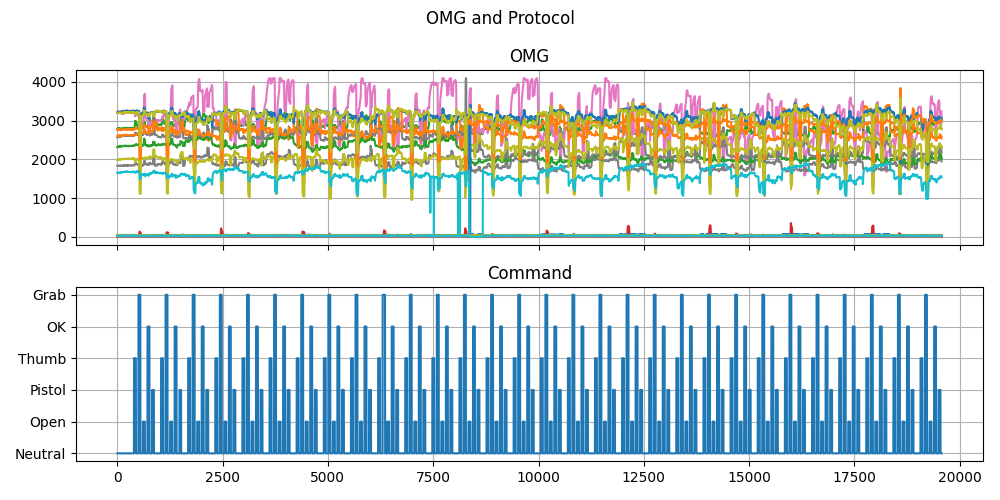

In [69]:
if DO_DRAW_PLOTS:
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
    plt.sca(axx[0])
    plt.plot(gestures[OMG_CH].values) # OMG_CH
    #plt.yticks(np.arange(0, 4500,500))
    #plt.pcolor(scaled_data.T)
    plt.grid()
    plt.title('OMG')
    
    plt.sca(axx[1])
    plt.plot(y_cmd)
    plt.grid()
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.title('Command')
    
    plt.suptitle('OMG and Protocol')
    plt.tight_layout()

In [70]:
# Функция смещения numpy массива
def shift(arr, n, fill=0):
    if n >= 0:
        return np.concatenate((np.full(n, fill), arr[:-n]))
    else:
        return np.concatenate((arr[-n:], np.full(-n, fill)))

In [71]:
# Смещение
y_cmd = shift(y_cmd, n=OFFSET) # fill=0 так как в начале у пилота жест Open

# Train-test split

In [72]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [73]:
# Узнаем последний индекс обучающей выборки для нужного файла
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

In [74]:
# Разделяем данные на обучающую и тестовую по индексу полученному с /data/meta_information.csv
X_train = gestures[ALL_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[ALL_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 56) (15679,)
(3889, 56) (3889,)


# Modeling

In [75]:
if DO_HYPEROPT:
    # зададим пространство поиска гиперпараметров
    solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    criterion = ['gini','entropy','log_loss']
    space={
           #'criterion': hp.choice('criterion',criterion),
           #'n_estimators': scope.int(hp.quniform('n_estimators', 1, 350,1)),
           #'max_depth': scope.int(hp.quniform('max_depth', 1, 35,1)),
           #'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 15,1)),
           #'C': hp.uniform('C', 0.01, 10),
           #'solver': hp.choice('solver',solver),
           #'max_iter': scope.int(hp.quniform('max_iter', 100, 10000, 100))
          }
    # функция которую оптимизируем
    def hyperopt_rf(params, cv=5, X=X_train, y=y_train):
        model = model_name(**params) # Создаем модель с тестируемыми параметрами
        skf = StratifiedKFold(n_splits=cv, shuffle=True) # кросс валидация
        score = cross_val_score(model, X, y, cv=skf, scoring="f1_micro", n_jobs=-1).mean()
        return -score
    # Подбор гиперпараметров Hyperopt
    trials = Trials() # используется для логирования результатов
    best=fmin(hyperopt_rf, # наша функция 
            space=space, # пространство гиперпараметров
            max_evals=10, # максимальное количество итераций
            timeout=180, # время выполнения
            trials=trials, # логирование результатов
            )
    # Приводим best_params в нужный вид
    for key,val in best.items():
        if key == 'criterion': # Если параметр criterion то берём значение из списка criterion
            best[key] = criterion[val]
        elif key == 'solver': # Если параметр solver то берём значение из списка solver
            best[key] = solver[val]
        elif val % 1 == 0: # Если число без цифр после запятой, но float, то меняем на int
            best[key] = int(val)
    print(f"Наилучшие значения гиперпараметров {best}")

In [76]:
DO_MMSCALER = True
if DO_MMSCALER:
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

In [77]:
# Создание модели
if model_name != None:
    model = model_name(**best)

model.fit(X=X_train, y=y_train)

LogisticRegression(C=1, max_iter=1000)

In [78]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10171
           1       0.99      0.84      0.91      1104
           2       0.96      0.85      0.90      1078
           3       0.94      0.79      0.86      1104
           4       0.91      0.79      0.84      1104
           5       0.96      0.92      0.94      1118

    accuracy                           0.93     15679
   macro avg       0.95      0.86      0.90     15679
weighted avg       0.93      0.93      0.93     15679

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2488
           1       0.97      0.85      0.90       276
           2       0.90      0.93      0.92       296
           3       0.85      0.53      0.65       276
           4       0.72      0.85      0.78       276
           5       0.87      0.82      0.85       277

    accuracy                           0.90      3889
   macro avg       0.87

In [79]:
# Функция построения графика кривой обучения
def plot_learning_curve(model, X, y, cv=4, scoring="f1_micro"):
    # Вычисляем координаты для построения кривой обучения
    skf = StratifiedKFold(n_splits=cv, shuffle=True) # кросс валидация
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=skf, # кросс валидатор
        scoring=scoring,  # метрика
        train_sizes=np.linspace(0.05,1,10), # Кол-во разбиений
    )
    display = LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores,test_scores=valid_scores,score_name=scoring)
    display.plot()
    plt.title('Learning Curve')
    plt.yticks(np.arange(0,1.05,0.05))
    plt.grid()
    plt.show()
    return display
if DO_PLOT_LEARNING_CURVE:
    learn_curve_plot = plot_learning_curve(model,X_train,y_train)

## Prediction

In [80]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

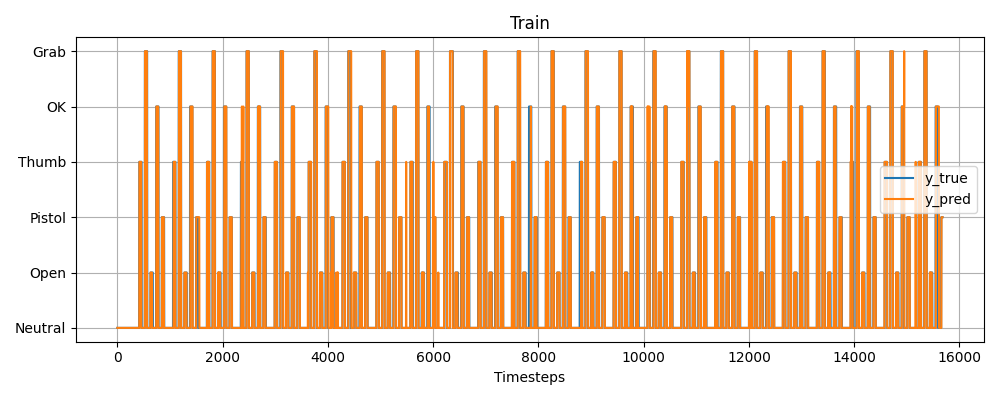

In [81]:
if DO_DRAW_PLOTS:
    # График истинных и предсказанных значений таргета в тренировочных данных
    fig = plt.figure(figsize=(10, 4))
    plt.plot(y_train,  c='C0', label='y_true')
    plt.plot(y_pred_train, c='C1', label='y_pred')
    
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.grid()
    plt.xlabel('Timesteps')
    plt.legend()
    plt.title('Train')
    plt.tight_layout()

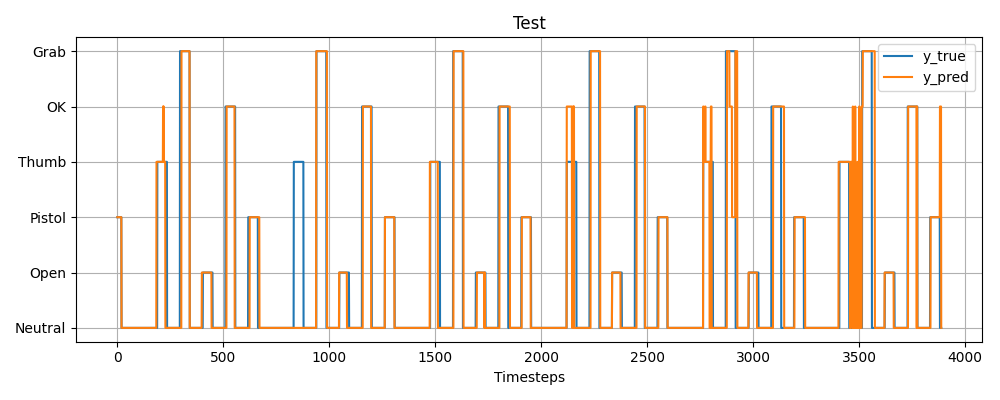

In [82]:
if DO_DRAW_PLOTS:
    # График истинных и предсказанных значений таргета в тестовых данных
    fig = plt.figure(figsize=(10, 4))
    plt.plot(y_test,  c='C0', label='y_true')
    plt.plot(y_pred_test, c='C1', label='y_pred')
    
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.grid()
    plt.xlabel('Timesteps')
    plt.legend()
    plt.title('Test')
    plt.tight_layout()

## Metrics

In [83]:
print_report()

========================= Train =========================
              precision    recall  f1-score   support

     Neutral       0.92      0.98      0.95     10171
        Open       0.99      0.84      0.91      1104
      Pistol       0.96      0.85      0.90      1078
       Thumb       0.94      0.79      0.86      1104
          OK       0.91      0.79      0.84      1104
        Grab       0.96      0.92      0.94      1118

    accuracy                           0.93     15679
   macro avg       0.95      0.86      0.90     15679
weighted avg       0.93      0.93      0.93     15679

========================= Test =========================
              precision    recall  f1-score   support

     Neutral       0.92      0.95      0.94      2488
        Open       0.97      0.85      0.90       276
      Pistol       0.90      0.93      0.92       296
       Thumb       0.85      0.53      0.65       276
          OK       0.72      0.85      0.78       276
        Grab     

# Real-time inference

In [84]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [85]:
def preprocessing(x): # Предобработка входных данных
    # x - sample vector
    y = x
    return y

def inference(x): # Предикт модели на данных
    y = model.predict([x])
    return y

def postprocessing(x, prev): # Постобработка результатов модели, сглаживаем с предыдущим предиктом
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [86]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [87]:
if DO_OFFLINE_INFERENCE:
    TIMEOUT = 0.033
    DEBUG = False

    i = 0
    ts_old = time.time()
    ts_diff = 0;
    ts_list = []

    y_previous = None
    y_dct = {
        'omg_sample':[],
        'enc_sample':[],
        'sample_preprocessed':[],

        'y_predicted':[],
        'y_postprocessed':[],
        'y_commands':[],
    }
    while True:    

        # [Data reading]
        ts_start = time.time()

        try:
            # [Sim data]
            if i < len(df_sim):
                sample = df_sim.values[i]
            else:
                break
            # [/Sim data]
            [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])

        except Exception as e:
            print(e)
        # [/Data Reading]

        # [Data preprocessing]
        sample_preprocessed = preprocessing(omg_sample)
        # [/Data preprocessing]

        # [Inference]
        y_predicted         = inference(sample_preprocessed)
        # [/Inference]

        # [Inference Postprocessing]
        y_postprocessed     = postprocessing(y_predicted, y_previous)
        # [/Inference Postprocessing]

        # [Commands composition]
        y_commands          = commands(y_postprocessed)
        # [/Commands composition]

        # [Commands sending]
        # NO COMMANDS SENDING IN SIMULATION
        # [/Commands sending]

        # [Data logging]
        y_dct['omg_sample'].append(omg_sample)
        y_dct['enc_sample'].append(enc_sample)
        y_dct['sample_preprocessed'].append(sample_preprocessed)
        y_dct['y_predicted'].append(y_predicted)
        y_dct['y_postprocessed'].append(y_postprocessed)
        y_dct['y_commands'].append(y_commands)
        # [/Data logging]

        y_previous = y_postprocessed

        if DEBUG:
            clear_output(wait=True)

            # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
            print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
            print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
            print(y_commands)

        # Считаем время выполнение инференса
        ts_diff = time.time() - ts_start

        ts_list.append(ts_diff)
        ts_old = ts_start
        i += 1 

    ts_mean = np.array(ts_list).mean()
    ts_max = np.array(ts_list).max()
    if ts_max > TIMEOUT:
        print('Calculation cycle takes more than TIMEOUT')
    print(f'Timeout: {TIMEOUT}')
    print(f'   mean: {round(ts_mean,5)}')
    print(f'    max: {round(ts_max,5)}')

In [88]:
if DO_OFFLINE_INFERENCE:
    for key, val in y_dct.items():
        # print(f"len({key}) = {len(y_dct[key])}")
        y_dct[key] = np.stack(val)
        print(f"{key}.shape = {y_dct[key].shape}")

In [89]:
if DO_OFFLINE_INFERENCE and DO_DRAW_PLOTS:
    fig = plt.figure(figsize=(10, 3))
    
    plt.plot(y_test, c='C0', label='y_cmd')
    plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
    plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
    plt.plot(y_dct['y_commands'], c='C3', label='y_commands')
    
    plt.title('Ground truth vs predicted vs postprocessed vs commands')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.legend()
    plt.grid()
    plt.xlabel('Timesteps')
    
    plt.tight_layout()

In [90]:
if DO_OFFLINE_INFERENCE:
    print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

### Online (prosthesis or virtual hand)

In [91]:
if DO_ONLINE_INFERENCE:
    TIMEOUT = 0.033
    DEBUG = True
    
    ser = None
    # ser_port = None
    # ser_port = '/dev/ttyACM0'
    ser_port = '/dev/cu.usbmodem3498365F31351'
    
    if ser_port is not None:
        ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
        ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
        ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
        ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check
    
        # flush buffers
        ser.reset_input_buffer()
        ser.read()
        
        i = 0;
        while(ser.in_waiting):
            print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
            ser.read_all()
            time.sleep(0.005)
            i+=1;
        ser.readline()
        ser.readline()
        
    i = 0
    ts_old = time.time()
    ts_diff = 0;
    
    y_previous = None
    while True:    
        
        # [Data reading]
        s = ser.readline()
        ts_start = time.time()
        
        try:
            sample = np.array(s.decode('UTF-8')\
                               .replace('\r\n', "")\
                               .split(' ')
                             ).astype(int)
            [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
            
        except Exception as e:
            print(e)
            
        # [/Data Reading]
            
        # [Data preprocessing]
        sample_preprocessed = preprocessing(omg_sample)
        # [/Data preprocessing]
        
        # [Inference]
        y_predicted         = inference(sample_preprocessed)
        # [/Inference]
        
        # [Inference Postprocessing]
        y_postprocessed     = postprocessing(y_predicted, y_previous)
        # [/Inference Postprocessing]
        
        # [Commands composition]
        y_commands          = commands(y_postprocessed)
        # [/Commands composition]
        
        # [Commands sending]
        pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
        # [/Commands sending]
        
        y_previous = y_postprocessed
        
        if DEBUG:
            clear_output(wait=True)
    
            # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
            print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
            print('INPUT:\n', s)
    
            # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
            print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
            print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
            print(y_commands)
            print(pack)
        
        ts_diff = time.time() - ts_start
        assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
        ts_old = ts_start
        i += 1 

# Log into comet.ml

In [92]:
if DO_LOG:
    # Создаем эксперимент у пользователя WORKSPACE в проекте PROJECT_NAME используя ключ API_KEY
    exp = Experiment(
        api_key=API_KEY,
        project_name=PROJECT_NAME,
        workspace=WORKSPACE,
    )
    try: exp.set_name(type(model).__name__)
    except:pass
    
    # Модель
    try: exp.log_text(text=type(model).__name__)
    except:pass
    # Параметеры
    try: exp.log_parameters(model.get_params())
    except:pass
    try: exp.log_parameters(best,prefix='best_')
    except:pass
    # Метрики
    train_metrics = f1_score(y_train, y_pred_train, average='micro')
    try: exp.log_metric(name='train',value=train_metrics)
    except:pass
    test_metrics = f1_score(y_test, y_pred_test, average='micro')
    try: exp.log_metric(name='test',value=test_metrics)
    except:pass
    # Время
    try: exp.log_metric(name='ts_mean',value=ts_mean)
    except:pass
    try: exp.log_metric(name='ts_max',value=ts_max)
    except:pass
    # График кривой обучения
    learn_curve_plot.plot()
    plt.title('Learning Curve')
    plt.yticks(np.arange(0,1.05,0.05))
    plt.grid()
    try: exp.log_figure(figure=plt)
    except:pass
    # Матрица ошибок
    try: exp.log_confusion_matrix(y_train.tolist(), y_pred_train.tolist())
    except:pass
    try: exp.log_confusion_matrix(y_test.tolist(), y_pred_test.tolist())
    except:pass
    
    exp.display()
    exp.end()